# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# magic word for producing visualizations in notebook
%matplotlib inline


import math




## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [3]:
azdias.iloc[:5,:12]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0


In [7]:
azdias['KBA05_AUTOQUOT'].value_counts()

3.0    258013
4.0    194706
2.0    123320
1.0     84157
5.0     82910
9.0     14791
Name: KBA05_AUTOQUOT, dtype: int64

In [4]:
customers.iloc[:5,:12]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,0.0
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,0.0
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,0.0


In [5]:
#Get the csv file with null values and the deature data
null_df = pd.read_csv("Null_Values_DIAS_2.csv")

#convert the df to a dictionary
import math
null_dict = null_df.set_index('Attribute').T.to_dict('list')
null_columns = {k:[int(elem) for elem in v if math.isnan(elem)==False] for k,v in null_dict.items()}

In [6]:
null_columns

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FR

In [7]:
#replace null values with np.nan in the df
azdias.replace(null_columns, np.nan, inplace=True)
customers.replace(null_columns, np.nan, inplace=True)

In [ ]:
#compress and save - delete file later
azdias.to_csv("azdias_null.csv.zip",compression="gzip")
customers.to_csv("customers_null.csv.zip",compression="zip")

In [2]:
#open the file - delete file later
azdias = pd.read_csv("azdias_null.csv.zip",compression='gzip')

/mnt/d/ML_venv/ML_basic_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
customers =pd.read_csv("customers_null.csv.zip",compression='zip')

In [6]:
azdias.head()


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


### head, info and shape can be used

In [5]:
print(azdias.shape)
print(customers.shape)

(891221, 367)
(191652, 370)


### 0.1 Data Preprocessing/cleaning

The azdias and custoemr dataframes contains a features with mixed datatypes, missing data and some features contain over 15 types of caegories. Thus to get a clean, complete and effective dataset following steps are done to both dataframes.

1. Get the null value/incomplete data value code (from /DIAS Attributes - Values 2017.xlsx) and convert those values to null in the df.
2. Get the missing value percentage of each feature and drop features which have more than 40% missing data.
3. Get the number of missing values for each row and drop rows which have large missing data. Exact cutoff value to be decided upon inspection of the data.
4. For features containing large number of catagories or object data type, either bin them into suitable sizes, or map them into integers or drop them.  
5. Impute the missing value with the most frequent value for each feature in the azdias dataset.
6. Scale features in to the same range.






In [ ]:
#get the null value codes from the excel file to convert df.
null_df = pd.read_csv("Null_Values_DIAS_2.csv")  #Get the csv file with null values and the deature data

null_dict = null_df.set_index('Attribute').T.to_dict('list')  #convert the df to a dictionary
null_columns = {k:[int(elem) for elem in v if math.isnan(elem)==False] for k,v in null_dict.items()}

In [ ]:
#replace null value codes with np.nan in the df
azdias.replace(null_columns, np.nan, inplace=True)
customers.replace(null_columns, np.nan, inplace=True)

In [106]:
#function to plot missing values percentage for features.

def plot_missingvalues_percentage(df_list, limit, plot_titles):
    """
    This function will take dataframes and calcualte the missing value percentage of each feature.
    Then plot the percentage above a set limit.
    
    Args: dataframe list, missing value percentage limit to plot, plot titles
    Return: None
    
    """
    Dataset = df_list
    missing_limit = limit   #set the limit for missing values to plot.
    titles = plot_titles
               
    fig, axes = plt.subplots(figsize=(14, 8) , nrows = 1, ncols = len(Dataset))  # Set up the matplotlib figure
    fig.tight_layout(pad=8.0)

    for i,data in enumerate(Dataset):
        feature =[]
        missing_value =[]
        total = data.shape[0]        

        for column in data:
            missing_col = 1-(data[column].count()/total)     #calculate the missing value percentage
            if  missing_col >= missing_limit:
                feature.append(column)
                missing_value.append(missing_col)

        axes[i].barh(y = feature, width=missing_value, height=0.4)  #plot the graph
        axes[i].set(xlabel='Missing Value %')
        axes[i].set_title(titles[i])
        axes[i].vlines(x = 0.4, ymin =feature[0], ymax=feature[-1], colors='r', linestyles='dashed') #add a cutoffline to plot
        for u, v in enumerate(missing_value):
            value = "{:.2f}".format(v)
            axes[i].text(v, u, str(value), color='blue', fontweight='bold')   


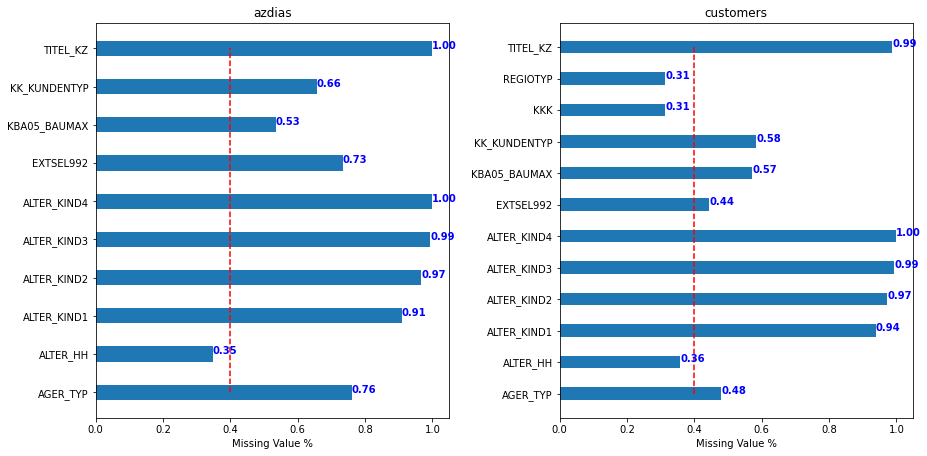

In [107]:
data_list = [azdias, customers]
data_titles = ['azdias', 'customers']
plot_missingvalues_percentage(data_list, 0.3, data_titles)

**Dropping features with higher missing value**
<br>
For this task, missing value percentage above 40% is dropped from the dfs. 
'AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ' features are dropped from both the dfs.
<br>
In addition 'CUSTOMER_GROUP','PRODUCT_GROUP','ONLINE_PURCHASE'  features are also dropped from the customers dfs.

In [7]:
#change the unamed column name to  delete 
azdias.rename(columns={'Unnamed: 0': "delete"}, inplace= True)
customers.rename(columns={'Unnamed: 0': "delete"}, inplace= True)

customers.head()


,delete,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [38]:
#drop columns which have more than 40% missing values from azdias and customers
#drop additional 'CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP' cloumns from customers

drop_azdias = ['delete', 'AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
drop_customers = ['delete','CUSTOMER_GROUP','PRODUCT_GROUP','ONLINE_PURCHASE','AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']

azdias.drop(columns= drop_azdias, inplace=True)
customers.drop(columns= drop_customers, inplace=True)


In [8]:
print(azdias.shape)
print(customers.shape)

(891221, 367)
(191652, 370)


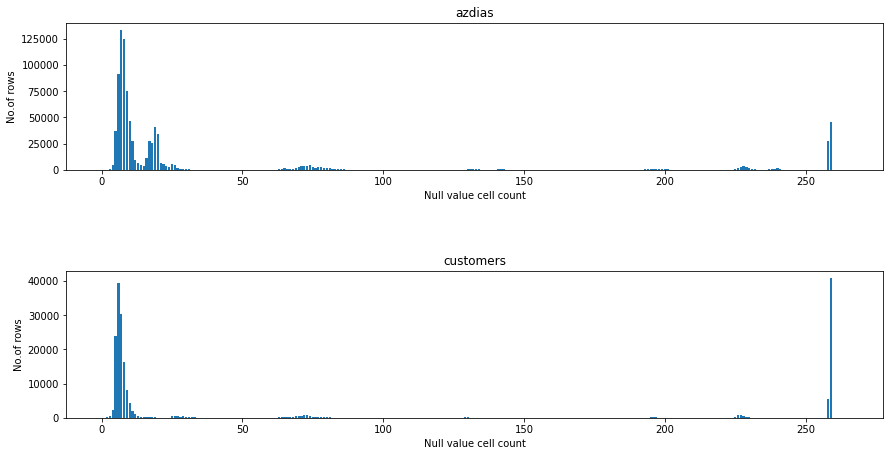

In [24]:
#plot the rows with the number of null value cell count

Dataset = [azdias, customers]
titles = ['azdias', 'customers']
fig, axes = plt.subplots(figsize=(14, 8) , nrows = len(Dataset), ncols = 1)  # Set up the matplotlib figure
fig.tight_layout(pad=8.0)

for i,data in enumerate(Dataset):
    missing_values_row = data.isnull().sum(axis=1).value_counts().index.tolist()
    missing_counts_row = data.isnull().sum(axis=1).value_counts().values.tolist()      

    axes[i].bar(x= missing_values_row, height=missing_counts_row, width=0.8)  #plot the graph
    axes[i].set(xlabel='Null value cell count')
    axes[i].set(ylabel='No.of rows')
    axes[i].set_title(titles[i])    
        


Both df has 357 features and 250 is selected as the cutoff value since more than that means the rows do not have 70% of the data.From the graph, we can see customers df has more missing cell values above the cutoff value. It should be noted that droping these rows will still retain majority of the data.

In [35]:
#drop rows which has more then 250 null cells

azdias.dropna(axis=0, thresh=250, inplace=True)
customers.dropna(axis=0, thresh=250, inplace=True)

In [39]:
print(azdias.shape)
print(customers.shape)

(785420, 357)
(140371, 357)


The next section will analyse features with object data type and convert data to integers or bin large groups into suitable sizes. 

In [40]:
#get the list of column names with dtype as object
obj_list = azdias.select_dtypes(include='object').columns
obj_list

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [41]:
obj_list_2 = customers.select_dtypes(include='object').columns
obj_list_2

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

Since object dtype features are same in azdias as well as customers (and later on in the mailout train/test data) function will be written for these features. Also, 'D19_LETZTER_KAUF_BRANCHE' column will be dropped due to follwoing reason.
'D19_LETZTER_KAUF_BRANCHE': No explanation is provided on the attribute in the addiaionl file and looking at the values, it seems like this column contain the group of the last tranctional activty group. Since detail transctional acitivity of individuals are provided in other columns , it is decided to drop this.  


In [53]:
#convert object dtype columns to ints dtype

def convertobjects(dataset):
    """
    convert object dtype features to integers by mapping.
    args: dataset
    return: None
    
    """
    CAMEO_dict = {"1": 1, "2": 2, "3": 3, "4": 4, "5":5, "6":6, "7":7, "8": 8, "9":9}
    
    #get the first element of the string and map.
    dataset['CAMEO_DEU_2015']= dataset['CAMEO_DEU_2015'].astype(str).str[0].map(CAMEO_dict)
    dataset['CAMEO_DEUG_2015']= dataset['CAMEO_DEUG_2015'].astype(str).str[0].map(CAMEO_dict)
    dataset['CAMEO_INTL_2015']= dataset['CAMEO_INTL_2015'].astype(str).str[0].map(CAMEO_dict)
    
    #extract the first 4 characters as a int
    dataset['EINGEFUEGT_AM']= dataset['EINGEFUEGT_AM'].str[:4].astype('float').astype('Int32')  
    
    dataset['OST_WEST_KZ']= dataset['OST_WEST_KZ'].map({"W":1 , "O":0})

In [54]:
convertobjects(azdias)
convertobjects(customers)

In [58]:
# customers['EINGEFUEGT_AM'] = customers['EINGEFUEGT_AM'].astype('float').astype('Int32')

In [61]:
# azdias['EINGEFUEGT_AM'] = azdias['EINGEFUEGT_AM'].astype('float').astype('Int32')

In [62]:
azdias.select_dtypes(include='object').columns

Index(['D19_LETZTER_KAUF_BRANCHE'], dtype='object')

In [65]:
#drop the object dtype columns and LNR
azdias.drop(columns= ['D19_LETZTER_KAUF_BRANCHE','LNR'], inplace=True)
customers.drop(columns= ['D19_LETZTER_KAUF_BRANCHE','LNR'], inplace=True)

In [35]:
#drop 'LNR' from the dataset  ---- Need to do this in first drop
# azdias.drop(columns= 'LNR', inplace=True)
# customers.drop(columns= 'LNR', inplace=True)

In [66]:
print(azdias.shape)
print(customers.shape)

(785420, 355)
(140371, 355)


Most of the features in the dfs are categorical type. Once the object dtype are succefully convert to ints/floats, the next step is to identify how many categories are there in each feature and if it is too large (high cardinality), reconstruct them in to smaller categories by binning.

In [70]:
#get the columns with more than 15 categories.
big_category_columns = []
for columns in azdias.columns:
    groups = azdias[columns].nunique()
#     print('{}  ----  {}'.format(columns, groups))
    if groups >15:
        big_category_columns.append(columns)   #list of columns with more than 15 unique data. 
        

In [71]:
big_category_columns

['ALTER_HH',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'LP_LEBENSPHASE_FEIN',
 'MIN_GEBAEUDEJAHR',
 'VERDICHTUNGSRAUM']

In [72]:
customers['ANZ_HH_TITEL'].value_counts()

0.0     132286
1.0       5111
2.0        453
3.0        105
4.0         56
6.0         49
13.0        39
7.0         27
8.0         25
5.0         22
9.0         13
14.0        12
11.0        12
20.0        10
10.0         8
17.0         7
15.0         5
18.0         5
12.0         4
Name: ANZ_HH_TITEL, dtype: int64

In [73]:
customers['ANZ_HAUSHALTE_AKTIV'].value_counts()

1.0      72198
2.0      22163
3.0       7709
4.0       4540
5.0       3575
         ...  
123.0        1
196.0        1
126.0        1
139.0        1
238.0        1
Name: ANZ_HAUSHALTE_AKTIV, Length: 208, dtype: int64

In [74]:
customers['ANZ_PERSONEN'].value_counts()

2.0     42295
1.0     39384
3.0     26477
4.0     15715
0.0      6872
5.0      6325
6.0      2270
7.0       703
8.0       215
9.0        63
10.0       22
11.0       12
12.0        9
14.0        3
13.0        2
21.0        2
16.0        1
15.0        1
Name: ANZ_PERSONEN, dtype: int64

In [21]:
azdias['GEBURTSJAHR'].replace(0, np.nan, inplace=True)   #update the null coiumn value
customers['GEBURTSJAHR'].replace(0, np.nan, inplace=True)   #update the null coiumn value

In [63]:
# Set up the matplotlib figure for the disribution of big_cat_columns

def distribution_graphs(features):
    fig, axes = plt.subplots(figsize=(12, 7) , nrows = 3, ncols = 4)
    fig.tight_layout(pad=4.0)

    for i in range(12):
        if i<4:
            axes[0,i].hist(x=azdias[features[i]].dropna(), color = 'blue', edgecolor = 'black')
            axes[0,i].set_title('{}'.format(features[i]))
        elif 4<=i<8:
            axes[1,i-4].hist(x=azdias[features[i]].dropna(), color = 'blue', edgecolor = 'black')
            axes[1,i-4].set_title('{}'.format(features[i]))
        elif 8<=i<12:   
            axes[2,i-8].hist(x=azdias[features[i]].dropna(), color = 'blue', edgecolor = 'black')
            axes[2,i-8].set_title('{}'.format(features[i]))
            

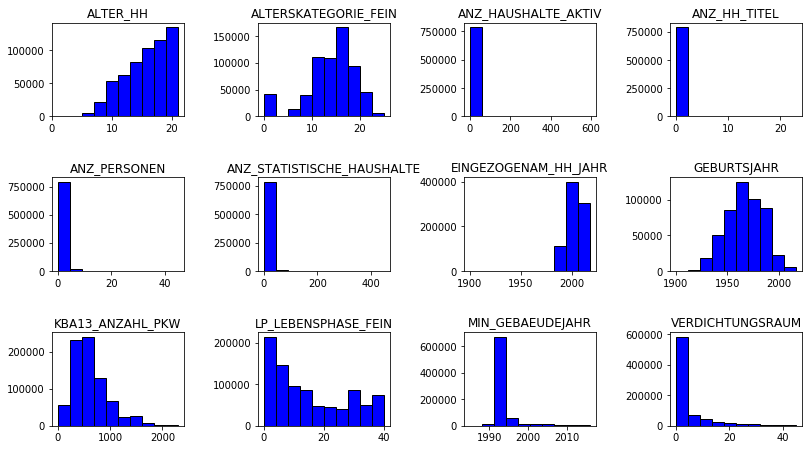

In [64]:
distribution_graphs(big_cat_columns)

In [96]:
#qcut binning to reclassify big_cat_columns 
qcut_features = ['ALTER_HH','ALTERSKATEGORIE_FEIN', 'EINGEZOGENAM_HH_JAHR','KBA13_ANZAHL_PKW','GEBURTSJAHR','ANZ_HAUSHALTE_AKTIV']
qcut_10_labels = [1,2,3,4,5,6,7,8,9,10]
qcut_7_labels = [1,2,3,4,5,6,7]

for feature in qcut_features:
    new_feature = str(feature)+'_2'

    if feature == 'ANZ_HAUSHALTE_AKTIV':
#         print('one')
        azdias[new_feature], bins = pd.qcut(azdias[feature], q=7,labels = qcut_7_labels, retbins=True)
        customers[new_feature] = pd.cut(customers[feature], bins, labels=qcut_7_labels, include_lowest=True)
    else:
#         print(new_feature)
        azdias[new_feature], bins = pd.qcut(azdias[feature], q=10,labels = qcut_10_labels, retbins=True)
        customers[new_feature] = pd.cut(customers[feature], bins, labels=qcut_10_labels, include_lowest=True)

ALTER_HH_2
ALTERSKATEGORIE_FEIN_2
EINGEZOGENAM_HH_JAHR_2
KBA13_ANZAHL_PKW_2
GEBURTSJAHR_2
one


In [97]:
#pd cut binning
cut_11_labels =  [0,1,2,3,4,5,6,7,8,9,10]
azdias['ANZ_HH_TITEL_2']= pd.cut(x= azdias['ANZ_HH_TITEL'], bins=[-1,0,1,2,3,4,5,6,7,8,9,23], labels = cut_11_labels)
azdias['ANZ_PERSONEN_2']= pd.cut(x= azdias['ANZ_PERSONEN'], bins=[-1,0,1,2,3,4,5,6,7,8,9,46], labels = cut_11_labels)
customers['ANZ_HH_TITEL_2']= pd.cut(x= customers['ANZ_HH_TITEL'], bins=[-1,0,1,2,3,4,5,6,7,8,9,23], labels = cut_11_labels)
customers['ANZ_PERSONEN_2']= pd.cut(x= customers['ANZ_PERSONEN'], bins=[-1,0,1,2,3,4,5,6,7,8,9,46], labels = cut_11_labels)

In [103]:
#drop big_cat_columns from the dfs
azdias.drop(columns= big_cat_columns, inplace=True)
customers.drop(columns= big_cat_columns, inplace=True)

In [112]:
#fill the missing values with the most common value in each column

Dataset = [azdias, customers]
for data in Dataset:
    null_list = data.columns[data.isna().any()].tolist()  #get the null value containig columns
    for column in null_list:
         data[column].fillna(value= data[column].mode().iloc[0], inplace=True) #fill with most common value

In [67]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785420 entries, 1 to 891220
Columns: 355 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: Int32(1), float64(267), int64(87)
memory usage: 2.1 GB


In [68]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140371 entries, 0 to 191651
Columns: 355 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: Int32(1), float64(267), int64(87)
memory usage: 380.9 MB


In [115]:
checklist = customers.columns[customers.isna().any()].tolist()
len(checklist)

0

In [ ]:
#save the cleaned file
azdias.to_csv("azdias_cleaned.zip",index = False, compression="zip")
customers.to_csv("customers_cleaned.zip",index = False, compression="zip")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
#open the cleaned files
azdias = pd.read_csv("azdias_cleaned.zip",compression='zip')
customers = pd.read_csv("customers_cleaned.zip",compression='zip')

### Apply PCA

In [5]:
#function to model pca and plot the variance
from sklearn.decomposition import PCA
from scipy.interpolate import make_interp_spline, BSpline

def pca_variance(dataframe, components):  #function to model pca and plot the variance graph
    variance = []
    for value in components:
        pca_model = PCA(n_components=value)  #model the pca
        pca_model.fit_transform(dataframe)   
        variance.append(pca_model.explained_variance_ratio_.cumsum()[value-1])  #get the variace value
    print(variance)
    print(components)
        
    #plot the variace
    components_smooth = np.linspace(components[0], components[-1], 10)  #10 points are selected to get a smooth line
    spl = make_interp_spline(components, variance, k=3)  # type: BSpline
    varaince_smooth = spl(components_smooth)
    
    plt.scatter(components, variance)   #plot the variance as a scatter graph
    plt.plot(components_smooth, varaince_smooth)  #plot the smooth line
    plt.ylabel("Variance Covered")
    plt.xlabel("PCA Components")
    plt.title("Variance covered by PCA Components")
    plt.show()

In [ ]:
#apply pca
pca_components = [110, 120, 130, 140, 150, 160, 170,180]
pca_variance(azdias,pca_components)

#This is run in colab for faster computing. The results are given in the next cell. 
#For more reference, colab notebook for pca is atached.

In [6]:
components = [110, 120, 130, 140, 150, 160, 170,180]
variance = [0.8218630006090925, 0.8412655807822145, 0.859175979216605, 0.8756760189295024, 0.8909399374647844, 0.9047352506022815,0.9171057845275419, 0.9280132999633186]


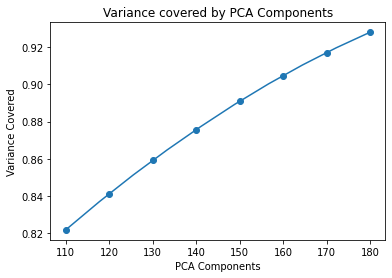

In [7]:
#plot the pca graph

components_smooth = np.linspace(components[0], components[-1], 10)  #10 points are selected to get a smooth line
spl = make_interp_spline(components, variance, k=3)  # type: BSpline
varaince_smooth = spl(components_smooth)

plt.scatter(components, variance)   #plot the variance as a scatter graph
plt.plot(components_smooth, varaince_smooth)  #plot the smooth line
plt.ylabel("Variance Covered")
plt.xlabel("PCA Components")
plt.title("Variance covered by PCA Components")
plt.show()

##### Considering the total variace captured by principal components, 170 PCA components is selected as it covers around 92% of the total variance.

In [ ]:
#select a good pca_component and transf0rm the dataset

pca_model = PCA(n_components=170)  #selected value 170

azdias_transformed = pca_model.fit_transform(azdias)  #fit and transform the azdias dataset
customers_transformed = pca_model.transform(customers) #transform the customers

### Elbow plot for k-means

In [ ]:
#plot the elbow graph to find the optimum k for k-means
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
for k in range(3,10):
    km = KMeans(n_clusters=k)
    km = km.fit(azdias_transformed)
    Sum_of_squared_distances.append(km.inertia_)


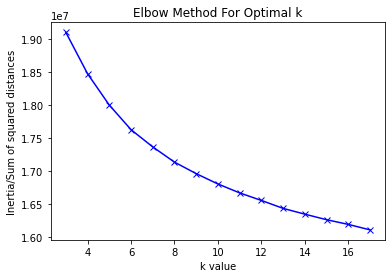

In [8]:
#Elbow graph is plotted in colab for faster performance. Results are plotted in here.

K = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
Sum_of_squared_distances = [19101670.897752788,18473412.900836088,17998313.638482377,17625599.474804416,17364182.332419813, 
                            17133268.665771253,16958477.17330367,16801939.93121694,16666725.068677064,16552372.559374245,
         16432142.602628695,16344327.71689674, 16260535.705382742,16189203.441679705,16106114.367119506]


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k value')
plt.ylabel('Inertia/Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()


Based on the elbow method, 8 is seleced as a good k value.

### Apply k-menas clustering

In [87]:
#open the cleaned files
azdias= pd.read_csv("azdias_transformed.gzip",compression='gzip')
customers= pd.read_csv("customers_transformed.gzip",compression='gzip')

In [88]:
azdias.head()

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,-1.262458,-1.366644,-1.006291,-0.160180,-0.685798,-1.786472,-0.222555,-0.002131,-0.139836,0.014822,...,0.032164,-0.108730,0.048029,0.092055,0.142903,-0.167326,-0.045630,-0.116774,-0.007438,0.001932
1,-1.818264,1.294131,-0.934025,1.881508,-0.144415,1.416541,-0.174874,-0.295500,-1.436023,-0.253875,...,0.055808,-0.182872,0.025936,-0.151042,0.349888,0.274372,0.041775,-0.157690,-0.193403,0.009808
2,-0.075750,-0.000964,-0.644911,1.109457,-0.623964,1.244952,1.331270,1.253994,1.188159,-0.994766,...,0.110362,-0.209966,-0.399512,-0.038592,0.312399,0.184343,0.051100,-0.063449,-0.123997,-0.003097
3,1.389092,-1.922397,-0.563339,0.414488,-0.119979,0.977940,-0.201678,0.036096,-0.346882,0.597050,...,-0.262175,0.065937,-0.002464,0.011603,0.160104,-0.091568,0.174741,-0.073589,-0.122319,0.018119
4,1.733425,1.931019,1.698991,0.385329,0.451856,-1.164693,-0.902004,0.589805,0.523459,0.683344,...,0.143684,0.557090,-0.225955,0.002856,-0.029614,0.014103,0.233657,-0.011296,-0.403514,-0.258973


In [89]:
customers.head()

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,2.577022,-2.212057,0.462295,1.171006,1.143311,0.028992,-0.314259,0.064057,0.307384,0.053282,...,0.078965,-0.351656,-0.193473,0.239393,0.295806,0.139963,-0.077457,0.442067,-0.021039,-0.021996
1,0.989375,-1.640664,0.287764,-0.124600,0.700622,-0.593600,0.100964,0.075785,0.311151,-0.004399,...,-0.135936,0.017130,-0.151628,0.134525,-0.235417,0.080205,0.020255,0.003939,0.058762,0.109880
2,0.033198,-1.966991,1.465943,0.840923,-0.812315,-0.137798,-0.579536,-1.161128,0.772321,1.658540,...,0.061411,0.158659,-0.489255,0.076911,0.132329,0.008967,0.190309,0.076749,0.412575,-0.093849
3,1.736152,-1.972577,0.183831,-0.672838,1.073929,-0.081035,0.344026,1.205592,-0.547860,0.579584,...,0.018531,0.100700,-0.211837,0.109875,0.191734,0.308058,-0.073221,0.110874,0.252127,-0.415366
4,0.925881,2.114115,1.114241,-0.758067,-0.008408,-1.182272,-1.538029,0.070950,0.110402,-0.394982,...,-0.120179,-0.104908,0.510133,0.348640,0.067688,-0.130623,-0.089777,0.242518,-0.145946,-0.154391


In [5]:
#apply kmenas clustering method for the dataset
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=8).fit(azdias)  #selected cluster size is 8
azdias_cluster = cluster_model.predict(azdias)
customers_cluster = cluster_model.predict(customers)

In [15]:
#get the azdias cluster points count
unique, azdias_counts = np.unique(azdias_cluster, return_counts=True)
print(unique)
print(azdias_counts)

[0, 1, 2, 3, 4, 5, 6, 7]
[113796, 138696, 80430, 142829, 124920, 126792, 85754, 78004]


In [11]:
#get the custoemrs cluster points count
unique2, customers_counts = np.unique(customers_cluster, return_counts=True)
print(unique2)
print(customers_counts)

[0 1 2 3 4 5 6 7]
[ 1684  2047 42066 40090 41030 18226  5425 41084]


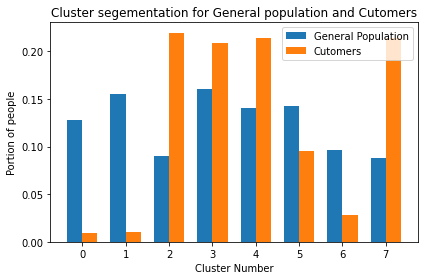

In [25]:
#plot graph

x = np.arange(len(unique))  # the label locations
width = 0.35  # the width of the bars

cluster_fig, cluster_ax = plt.subplots()
chart1 = cluster_ax.bar(x - width/2, azdias_counts/azdias_counts.sum(), width, label='General Population')
chart2 = cluster_ax.bar(x + width/2, customers_counts/customers_counts.sum(), width, label='Cutomers')

# Add some text for labels, title and custom x-axis tick labels, etc.
cluster_ax.set_ylabel('Portion of people')
cluster_ax.set_title('Cluster segementation for General population and Cutomers')
cluster_ax.set_xlabel('Cluster Number')
cluster_ax.set_xticks(x)
cluster_ax.set_xticklabels(unique)
cluster_ax.legend()
cluster_fig.tight_layout()

plt.show()

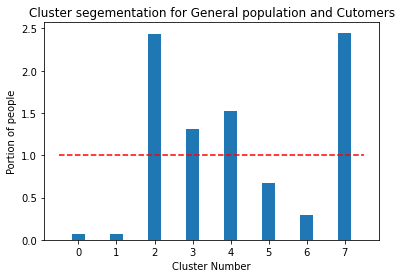

In [41]:
#plot the ratio for each cluster grph

cluster_ratio = (customers_counts/customers_counts.sum())/(azdias_counts/azdias_counts.sum()) #caluclate the ratio

ratio_chart = plt.bar(x, cluster_ratio,width)
plt.ylabel('Portion of people')
plt.title('Cluster segementation for General population and Cutomers')
plt.xlabel('Cluster Number')
plt.hlines(y=1, xmin=-0.5, xmax=7.5, colors='r',linestyles='dashed')
plt.xticks(x)
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [90]:
#open the file - delete file later
mailout_train = pd.read_csv("mailout_train.gzip",compression='gzip')


/mnt/d/ML_venv/ML_basic_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [91]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1.0,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1.0,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2.0,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2.0,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


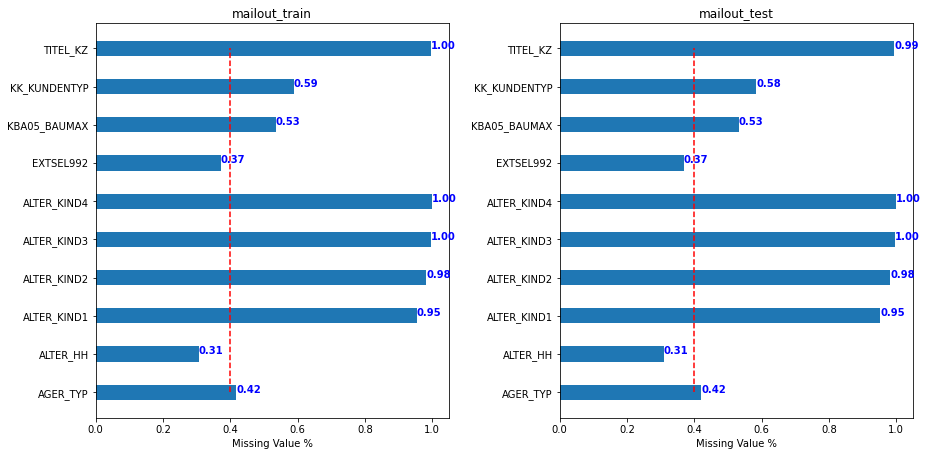

In [108]:
data_list2 = [mailout_train, mailout_test]
data_titles2 = ['mailout_train', 'mailout_test']
plot_missingvalues_percentage(data_list2, 0.3, data_titles2)


In [46]:
#drop columns with more than 40% missing values--- in the cluster case change it to 40 instead of 50
drop_mailout = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']

# Remove EXTSEL992 - no discription given and large data group
mailout_train.drop(columns= drop_mailout, inplace=True)
mailout_test.drop(columns= drop_mailout, inplace=True)


In [47]:
print(mailout_train.shape)
print(mailout_test.shape)

(42962, 359)
(42833, 358)


In [51]:
obj_list = mailout_train.select_dtypes(include='object').columns
obj_list

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [50]:
obj_list2 = mailout_test.select_dtypes(include='object').columns
obj_list2

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [53]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 359 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(265), int64(88), object(6)
memory usage: 117.7+ MB


In [54]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 358 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(265), int64(87), object(6)
memory usage: 117.0+ MB


In [55]:
convertobjects(mailout_train)
convertobjects(mailout_test)

In [59]:
#drop the object dtype columns
object_dtype_drop = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
mailout_train.drop(columns= object_dtype_drop, inplace=True)
mailout_test.drop(columns= object_dtype_drop, inplace=True)

In [60]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 357 entries, LNR to CAMEO_INTL_2015_2
dtypes: float64(269), int64(88)
memory usage: 117.0 MB


In [61]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 356 entries, LNR to CAMEO_INTL_2015_2
dtypes: float64(269), int64(87)
memory usage: 116.3 MB


In [67]:
big_cat_columns2 = []
for columns in mailout_train.columns:
    groups = mailout_train[columns].nunique()
#     print('{}  ----  {}'.format(columns, groups))
    if groups >=15:
        big_cat_columns2.append(columns)   #list of columns with more than 15 unique data. 
        

In [68]:
big_cat_columns2  #simialar ro the previous one .. remove the lnr and extsel

['LNR',
 'ALTER_HH',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'LP_LEBENSPHASE_FEIN',
 'MIN_GEBAEUDEJAHR',
 'PRAEGENDE_JUGENDJAHRE',
 'VERDICHTUNGSRAUM']

In [64]:
mailout_train['GEBURTSJAHR'].value_counts()

0       17475
1941      918
1939      871
1940      847
1938      791
        ...  
1908        1
2003        1
2002        1
1905        1
2000        1
Name: GEBURTSJAHR, Length: 108, dtype: int64

In [65]:
mailout_train['GEBURTSJAHR'].replace(0, np.nan, inplace=True)   #update the null coiumn value
mailout_test['GEBURTSJAHR'].replace(0, np.nan, inplace=True)   #update the null coiumn value

In [72]:
#qcut binning to reclassify big_cat_columns2 
qcut_features = ['ALTER_HH','ALTERSKATEGORIE_FEIN', 'EINGEZOGENAM_HH_JAHR','KBA13_ANZAHL_PKW','GEBURTSJAHR','ANZ_HAUSHALTE_AKTIV']
qcut_10_labels = [1,2,3,4,5,6,7,8,9,10]
qcut_7_labels = [1,2,3,4,5,6,7]

for feature in qcut_features:
    new_feature = str(feature)+'_2'

    if feature == 'ANZ_HAUSHALTE_AKTIV':
#         bins = #include from azdias
        mailout_train[new_feature] = pd.cut(mailout_test[feature], bins, labels=qcut_7_labels, include_lowest=True)
        mailout_test[new_feature] = pd.cut(mailout_test[feature], bins, labels=qcut_7_labels, include_lowest=True)
    else:
#         bins = #include from azdias
        mailout_train[new_feature] = pd.cut(mailout_test[feature], bins, labels=qcut_10_labels, include_lowest=True)
        mailout_test[new_feature] = pd.cut(mailout_test[feature], bins, labels=qcut_10_labels, include_lowest=True)

ValueError: Bin edges must be unique: array([ 3.,  8.,  9.,  9., 10., 11., 13., 15., 17., 19., 21.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [73]:
#pd cut binning
cut_11_labels =  [0,1,2,3,4,5,6,7,8,9,10]
mailout_train['ANZ_HH_TITEL_2']= pd.cut(x= mailout_train['ANZ_HH_TITEL'], bins=[-1,0,1,2,3,4,5,6,7,8,9,23], labels = cut_11_labels)
mailout_train['ANZ_PERSONEN_2']= pd.cut(x= mailout_train['ANZ_PERSONEN'], bins=[-1,0,1,2,3,4,5,6,7,8,9,46], labels = cut_11_labels)
mailout_test['ANZ_HH_TITEL_2']= pd.cut(x= mailout_test['ANZ_HH_TITEL'], bins=[-1,0,1,2,3,4,5,6,7,8,9,23], labels = cut_11_labels)
mailout_test['ANZ_PERSONEN_2']= pd.cut(x= mailout_test['ANZ_PERSONEN'], bins=[-1,0,1,2,3,4,5,6,7,8,9,46], labels = cut_11_labels)

In [74]:
#fix the qcut before running


#drop big_cat_columns2 from the dfs
mailout_train.drop(columns= big_cat_columns2, inplace=True)
mailout_test.drop(columns= big_cat_columns2, inplace=True)

In [75]:
#fill the missing values with the most common value in each column

Dataset = [mailout_train, mailout_test]
for data in Dataset:
    null_list = data.columns[data.isna().any()].tolist()  #get the null value containig columns
    for column in null_list:
         data[column].fillna(value= data[column].mode().iloc[0], inplace=True) #fill with most common value

In [78]:
mailout_train.head()

,AKT_DAT_KL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_2,CAMEO_DEUG_2015_2,CAMEO_INTL_2015_2,GEBURTSJAHR_2,ANZ_HH_TITEL_2,ANZ_PERSONEN_2
0,1.0,0.0,1.0,0.0,3.0,5.0,2.0,5.0,2.0,2.0,...,3,0,2,4,5.0,5.0,3.0,3,0,1
1,4.0,0.0,2.0,0.0,2.0,5.0,2.0,2.0,2.0,2.0,...,1,0,2,3,5.0,5.0,3.0,8,0,2
2,1.0,0.0,0.0,0.0,4.0,1.0,4.0,5.0,1.0,1.0,...,3,0,1,4,2.0,2.0,1.0,1,0,0
3,1.0,0.0,2.0,0.0,4.0,2.0,2.0,5.0,2.0,2.0,...,3,0,2,4,2.0,2.0,1.0,1,0,2
4,1.0,0.0,1.0,0.0,3.0,4.0,6.0,5.0,1.0,2.0,...,3,0,1,3,7.0,7.0,4.0,3,0,1


In [102]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2.0,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2.0,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1.0,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [84]:
set(mailout_train.columns)-set(mailout_test.columns)

{'RESPONSE'}

In [85]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [77]:
checklist = mailout_train.columns[data.isna().any()].tolist()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 346 but corresponding boolean dimension is 345

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [92]:
mailout_test = pd.read_csv("mailout_test.gzip",compression='gzip')

/mnt/d/ML_venv/ML_basic_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
